**In this example, we will look at basic data cleaning, model selection, regularization with cross-validation and finally feature selection**

In [ ]:
# ====================
# Import libaries
# ====================

# Core
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import Image
from IPython.display import display

# skcikit-learn
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


In [30]:
# Read data
data_new = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data_new['YEAR'] = data_new['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data_new = data_new.loc[(data_new['VISCODE'] == "bl") & (data_new['ORIGPROT'] == "ADNI1"), :]

In [58]:
# ======================
# Model data processing
# ======================

def get_model_data(data, response_col, model_cols):

    # Split into train and test datasets
    data_train, data_test = train_test_split(data, test_size=0.3, random_state=87)
    print("Observations in train dataset: {}".format(len(data_train)))
    print("Observations in test dataset: {}".format(len(data_test)))
    
    # Response data
    y_train, y_test = data_train[response_col], data_test[response_col]

    # Model predictors
    X_train, X_test = data_train[model_cols], data_test[model_cols]
    
    # Drop predictors with very high proportion (90%+) of missing values
    df = X_train.apply(lambda x: x.isnull().sum() / len(X_train))
    keep_cols = list(df[df<0.9].index)
    X_train = X_train[keep_cols]
    X_test = X_test[keep_cols]  
    
    # Method to impute missing values using k-means clustering
    def kmeans_missing(X, n_clusters, max_iter=10):

        # Initialize missing values to their column means
        missing = ~np.isfinite(X)
        mu = np.nanmean(X, 0, keepdims=1)
        X_hat = np.where(missing, mu, X)

        for i in range(max_iter):
            if i > 0:
                cls = KMeans(n_clusters, init=prev_centroids)
            else:
                cls = KMeans(n_clusters, n_jobs=-1)

            # Perform clustering on the filled-in data
            labels = cls.fit_predict(X_hat)
            centroids = cls.cluster_centers_

            # Fill in the missing values based on their cluster centroids
            X_hat[missing] = centroids[labels][missing]

            # When the labels have stopped changing then we have converged
            if i > 0 and np.all(labels == prev_labels):
                break

            prev_labels = labels
            prev_centroids = cls.cluster_centers_

        return X_hat
    
    # Proportion of features with missing values by observation
    X_train['Proportion_missing'] = X_train.isnull().sum(axis=1) / X_train.shape[1]
    X_test['Proportion_missing'] = X_test.isnull().sum(axis=1) / X_test.shape[1]

    # Update model_cols list
    model_cols = list(X_train.columns)

    # Missing value imputation
    X_train = kmeans_missing(X_train, n_clusters=10)
    X_test = kmeans_missing(X_test, n_clusters=10)

    check = np.isnan(X_train).sum() + np.isnan(X_test).sum()
    if check != 0:
        raise ValueError("Missing values in train/test data.")
        
    # Standardize predictors
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, model_cols

# Baseline Model

In [42]:
#########
#Build a baseline model with only known predictors - ex MRI/PET/CSF
#########

#Choose predictors hypothesized as very important for with DX_bl

cols = ["AGE","PTEDUCAT","PTAU_UPENNBIOMK9_04_19_17","ABETA_UPENNBIOMK9_04_19_17", \
        "TAU_UPENNBIOMK9_04_19_17","APOE4","ADAS11"]

y = data_new['DX_bl']
X = data_new[cols]


#Case 2: impute missing values by mean
X = X.fillna(X.mean())

"""
imputer = Imputer(strategy='mean')
for col in X.columns:
    imputed = imputer.fit_transform(X[col].values.reshape(-1,1))
    X.loc[:,col] = imputed
"""

#Case 3: impute via model limputation



"\nimputer = Imputer(strategy='mean')\nfor col in X.columns:\n    imputed = imputer.fit_transform(X[col].values.reshape(-1,1))\n    X.loc[:,col] = imputed\n"

In [43]:
#Check for empty values after imputation
X.apply(lambda x: x.isnull().sum(), axis=0)

AGE                           0
PTEDUCAT                      0
PTAU_UPENNBIOMK9_04_19_17     0
ABETA_UPENNBIOMK9_04_19_17    0
TAU_UPENNBIOMK9_04_19_17      0
APOE4                         0
ADAS11                        0
dtype: int64

In [44]:
# Find unique response
np.unique(y_test,return_counts=True)

(array(['AD', 'CN', 'LMCI'], dtype=object), array([ 61,  90, 120]))

## Accuracies and confusion matrices of various "out-of-the-box" classification models

In [45]:
#method 1 - Build a regularized logistic regression model

#Standardize our variables - we only have continuous variables here in the baseline model
norm_X = (X-X.mean())/X.std()

#Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33)

#Determine baseline accuracy of various models

models = [LogisticRegressionCV(penalty='l2',fit_intercept=True),AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,criterion = 'gini'),n_estimators=50),\
          RandomForestClassifier(n_estimators=20, max_features='sqrt'),LinearDiscriminantAnalysis(solver='eigen'),\
          QuadraticDiscriminantAnalysis(),\
         DecisionTreeClassifier(max_depth=20,criterion = 'gini'),svm.SVC(kernel='linear')]

baseline_accuracies = {}

for model in models:
    #log_reg = LogisticRegressionCV(penalty='l2',fit_intercept=True)
    model.fit(X_train,y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    print("Accuracy score of the {} on the training set: {:.5f}" .format(str(model.__class__).split('.')[-1].strip("'>"),accuracy_score(y_train,y_train_predict)))
    print("Accuracy score of the {} on the test set: {:.5f}" .format(str(model.__class__).split('.')[-1].strip("'>"),accuracy_score(y_test,y_test_predict)))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, y_test_predict),"\n")
    baseline_accuracies[str(model.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)

Accuracy score of the LogisticRegressionCV on the training set: 0.68978
Accuracy score of the LogisticRegressionCV on the test set: 0.68266
Confusion matrix:
[[ 37   1  28]
 [  0  44  21]
 [ 15  21 104]] 

Accuracy score of the AdaBoostClassifier on the training set: 0.74453
Accuracy score of the AdaBoostClassifier on the test set: 0.57196
Confusion matrix:
[[30  0 36]
 [ 1 29 35]
 [28 16 96]] 

Accuracy score of the RandomForestClassifier on the training set: 0.99635
Accuracy score of the RandomForestClassifier on the test set: 0.64576
Confusion matrix:
[[37  2 27]
 [ 1 46 18]
 [28 20 92]] 

Accuracy score of the LinearDiscriminantAnalysis on the training set: 0.66606
Accuracy score of the LinearDiscriminantAnalysis on the test set: 0.66421
Confusion matrix:
[[ 32   0  34]
 [  0  29  36]
 [ 10  11 119]] 

Accuracy score of the QuadraticDiscriminantAnalysis on the training set: 0.67518
Accuracy score of the QuadraticDiscriminantAnalysis on the test set: 0.63469
Confusion matrix:
[[32  

## Plotting ROC Curves for Multi-Classification problem

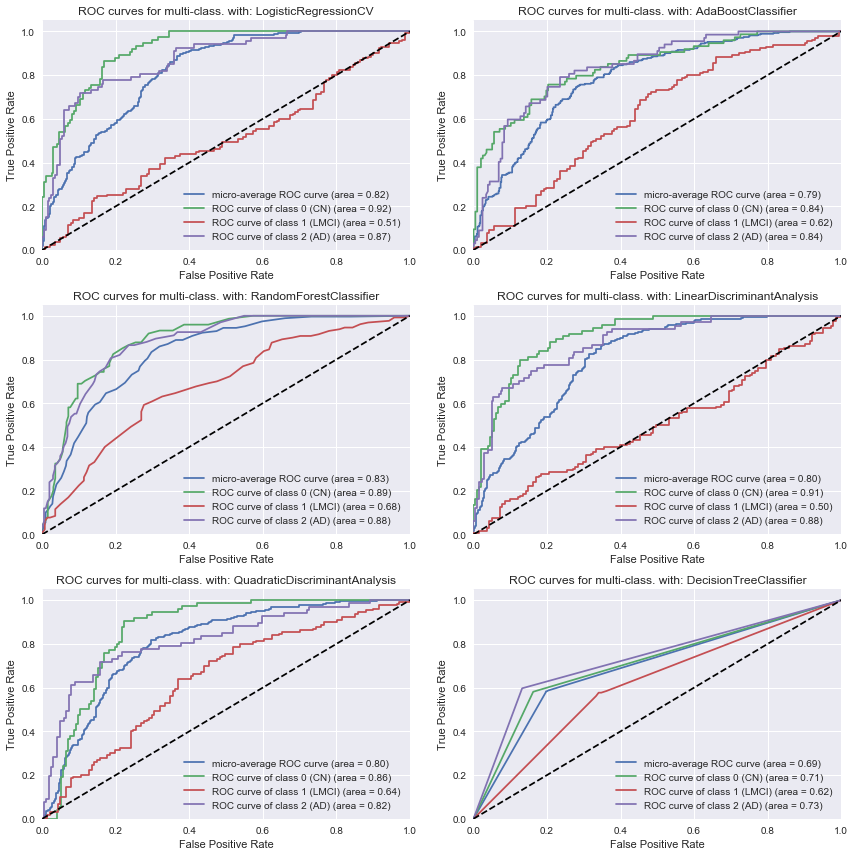

In [46]:


#reload y and nromalize X
y = data_new['DX_bl']

# Binarize the output
y = label_binarize(y, classes=['CN','LMCI','AD'])
n_classes = y.shape[1]

random_state =0 
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33
                                                    ,random_state=0)

#NOTE: Computing ROC for SVM is too computationally expensive
models = [LogisticRegressionCV(penalty='l2',fit_intercept=True),AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,criterion = 'gini'),n_estimators=50),\
          RandomForestClassifier(n_estimators=50, max_features='sqrt'),LinearDiscriminantAnalysis(solver='eigen'),\
          QuadraticDiscriminantAnalysis(),\
         DecisionTreeClassifier(max_depth=20,criterion = 'gini')]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
ax = axes.ravel()

for index,model in enumerate(models):

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)

    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve

    ax[index].plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i,label in zip(range(n_classes),['CN','LMCI','AD']):
        ax[index].plot(fpr[i], tpr[i], label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                                       ''.format(i,label, roc_auc[i]));

    ax[index].plot([0, 1], [0, 1], 'k--');
    ax[index].set_xlim([0.0, 1.0])
    ax[index].set_ylim([0.0, 1.05])
    ax[index].set_xlabel('False Positive Rate')
    ax[index].set_ylabel('True Positive Rate')
    ax[index].set_title('ROC curves for multi-class. with: {0}'.format(str(model.__class__).split('.')[-1].strip("'>")))
    ax[index].legend(loc="lower right");
    
plt.tight_layout()

In [47]:
#Now, build a model which has ALL predictors

y = data_new['DX_bl']
X = data_new.copy(deep=True).drop('DX_bl',axis=1)

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

#Split test & train datasets
X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33)

#Determine baseline accuracy of various models

models = [LogisticRegressionCV(penalty='l2',fit_intercept=True),AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,criterion = 'gini'),n_estimators=50),\
          RandomForestClassifier(n_estimators=20, max_features='sqrt'),LinearDiscriminantAnalysis(solver='eigen'),\
          QuadraticDiscriminantAnalysis(),\
         DecisionTreeClassifier(max_depth=20,criterion = 'gini'),svm.SVC(kernel='linear')]
accuracies_all_f = {}
for model in models:
    model.fit(X_train,y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    accuracies_all_f[str(model.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)

# Display baseline accuracies
for key in baseline_accuracies:
    print(key,": difference in accuracy \nwith chosen base predictors minus FULL set of predictors")
    print(baseline_accuracies[key]-accuracies_all_f[key])

LogisticRegressionCV : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0184501845018
AdaBoostClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.0110701107011
RandomForestClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.029520295203
LinearDiscriminantAnalysis : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0184501845018
QuadraticDiscriminantAnalysis : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.00738007380074
DecisionTreeClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0221402214022
SVC : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.00369003690037


<br>We see that including all predictors compared to just previously selected baseline predictors leads to approximately comparable accuracy across all out-of-the-box models.</br>
<br><b>Let's regularize the three best-performing models to get the baseline models and let's use only the limited set of predictors. </b>

 - Random Forest Classifier
 - ADA Boost Classifier
 - Support Vector Machine (SVM) Classifi

In [38]:
####BASELINE MODELS - SEE BELOW FOR CODE FOR ADA, RF and SVM

cols = ["AGE","PTEDUCAT","PTAU_UPENNBIOMK9_04_19_17","ABETA_UPENNBIOMK9_04_19_17", \
        "TAU_UPENNBIOMK9_04_19_17","APOE4","ADAS11"]

y = data_new['DX_bl']
X = data_new[cols]

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

#Standardize - IN end model, we should standardize AFTER splitting
standard_X = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(standard_X, y, test_size=0.33)

###############
#NOTE: all models can be adjusted to include polynomial features by changing the features degree
###############

#ADA Boost with Decision tree as a classifier

ADA_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('ADA', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion = 'gini'))
                           )])
ADA_param_grid = [{'ADA__n_estimators': [2, 3, 5, 10,50,100]},
                 {'ADA__base_estimator__max_depth':[2,3,4,5,None]}]


ADA_grid = GridSearchCV(ADA_pipe, param_grid=ADA_param_grid,cv = 5)

ADA_grid.fit(X_train, y_train)

print("Test accuracy achieved with ADA", ADA_grid.score(X_test,y_test))

#RF with optimized meta attributes max_depth and number of trees
RF_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('RF', RandomForestClassifier())
                           ])
RF_param_grid = [{'RF__n_estimators': [2, 3, 5, 10,50,100,150]},
                 {'RF__max_depth':[2,3,4,5,None]}]

RF_grid = GridSearchCV(RF_pipe, param_grid=RF_param_grid,cv = 5)

RF_grid.fit(X_train, y_train)

print("Test accuracy achieved with RF", RF_grid.score(X_test,y_test))

#SVM with optimized meta attributes regularization param C and kernel 

SVM_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('SVM', svm.SVC())
                           ])

SVM_param_grid = [{'SVM__C': np.logspace(-4,3)},
                  {'SVM__kernel':['linear','poly','rbf']},{'SVM__degree':[1,2,3,4]}]

SVM_grid = GridSearchCV(SVM_pipe, param_grid=SVM_param_grid,cv = 5)

SVM_grid.fit(X_train, y_train)

print("Test accuracy achieved with SVM", SVM_grid.score(X_test,y_test))

Test accuracy achieved with ADA 0.571955719557
Test accuracy achieved with RF 0.656826568266
Test accuracy achieved with SVM 0.638376383764


# Selecting Features

In [53]:
#use meta_data file to choose feature categories to add

data_meta = pd.read_csv('../data/metadata.csv')

#list of categories
categories = list(np.unique(data_meta.cat))
categories


['CSF',
 'Cognitive tests',
 'Cognitive tests (ADAS)',
 'Demographics',
 'Diagnosis',
 'Family History',
 'Family history',
 'Genetic marker',
 'ID',
 'MRI (Cross-sectional)',
 'MRI (Longitudinal)',
 'MRI measures',
 'PET (AV45 AMYLOID)',
 'PET (FDG)',
 'PET measures',
 'Time']

In [60]:
# Import metadata file
meta = pd.read_csv('../data/metadata.csv')

# Cost assumptions
cost_assumptions = pd.read_csv('../data/cost_assumptions.csv')

# Standardize the upper/lower letters across ADNIMERGE and FHQ source
meta['cat']=meta.cat.apply(lambda x: 'Family History' if x == 'Family history' else x)

meta_data = meta.merge(cost_assumptions, on="cat")



In [61]:
response_col = "DX_bl"
class_names = ['CN','LMCI','AD']

# Create list of baseline predictors from metadata
baseline_cols = list(meta_data.loc[meta_data.baseline==1,'column_name'])

# Sources in addition to baseline
source_list = ['NEUROBAT', 'UCSFFSX', 'UPENNBIOMK9', 'ADASSCORES', 'PTDEMOG', 'FHQ', 'TOMM40']

#select full cols
model_cols = baseline_cols + list(meta_data[meta_data['source'].isin(source_list)]['column_name'])


In [62]:
X_train, X_test, y_train, y_test, model_cols = get_model_data(data_new, response_col, model_cols)

Observations in train dataset: 573
Observations in test dataset: 246


/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


## Use Support Vector Machine for a backwards feature selection

In [63]:
#Now perform sort-of a backwards feature selection

SVM_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('SVM', svm.SVC())
                           ])

SVM_param_grid = [{'SVM__C': np.logspace(-4,3)},
                  {'SVM__kernel':['linear','poly','rbf']},{'SVM__degree':[1,2,3,4,5,6,7,8]}]

SVM_grid = GridSearchCV(SVM_pipe, param_grid=SVM_param_grid,cv = 5)

SVM_grid.fit(X_train, y_train)

print("Train accuracy achieved with SVM", SVM_grid.score(X_train,y_train))
print("Test accuracy achieved with SVM", SVM_grid.score(X_test,y_test))

Train accuracy achieved with SVM 0.975567190227
Test accuracy achieved with SVM 0.711382113821


In [308]:
SVM_grid.cv_results_

{'mean_fit_time': array([ 0.00716763,  0.00645199,  0.00630002,  0.00703726,  0.00626993,
         0.00741553,  0.0081543 ,  0.00849576,  0.00687895,  0.00633144,
         0.00633373,  0.00648603,  0.00636816,  0.00703368,  0.0066092 ,
         0.00651479,  0.00652461,  0.00630136,  0.00631008,  0.00619259,
         0.00620236,  0.0060864 ,  0.00585217,  0.00572433,  0.00565958,
         0.00549607,  0.00545969,  0.00692024,  0.00592599,  0.00639338,
         0.00579152,  0.00579562,  0.006039  ,  0.00636368,  0.00687137,
         0.00708923,  0.00799241,  0.00852108,  0.00967431,  0.01076398,
         0.01252937,  0.01531177,  0.01933126,  0.02273688,  0.02974753,
         0.03258276,  0.04031649,  0.04890237,  0.05976448,  0.07405133,
         0.00618124,  0.00528522,  0.00564766,  0.00553412,  0.00548558,
         0.00544219,  0.00554681,  0.00546947,  0.00544071,  0.00547061,
         0.00549436]),
 'mean_score_time': array([ 0.00186534,  0.00150123,  0.00136881,  0.00148973,  0.00